In [1]:
from sklearn.datasets import load_files       
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    bur_files = np.array(data['filenames'])
    bur_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return bur_files, bur_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('BurImagesJPG/train/color')
validation_files, validation_targets = load_dataset('BurImagesJPG/validation/color')
test_files, test_targets = load_dataset('BurImagesJPG/test/color')

# load list of bur classes
bur_classes = [item[25:-1] for item in sorted(glob("BurImagesJPG/train/color/*/"))]

# print statistics about the dataset
print('There are %d total Bur classes.' % len(bur_classes))
print bur_classes
print('There are %s total Bur images.\n' % len(np.hstack([train_files, test_files, validation_files])))
print('There are %d training Bur images.' % len(train_files))
print('There are %d validation Bur images.' % len(validation_files))
print('There are %d test Bur images.\n'% len(test_files))
print('There are %d training Bur targets.' % len(train_targets))
print train_targets.sum(axis=0)

Using TensorFlow backend.


There are 2 total Bur classes.
['damaged', 'good']
There are 936 total Bur images.

There are 674 training Bur images.
There are 136 validation Bur images.
There are 126 test Bur images.

There are 674 training Bur targets.
[308. 366.]


(674,)
['BurImagesJPG/train/color/good/20180826-173620GoodBur.jpg'
 'BurImagesJPG/train/color/damaged/20180826-091649DamagedBur.jpg'
 'BurImagesJPG/train/color/good/20180924-200517GoodBur.jpg'
 'BurImagesJPG/train/color/good/20180826-175847GoodBur.jpg'
 'BurImagesJPG/train/color/damaged/20180826-093455DamagedBur.jpg']
(674, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


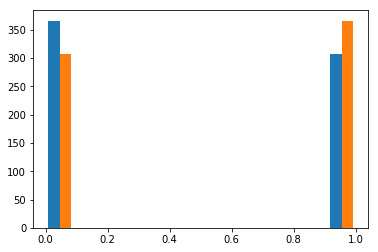

In [2]:
print train_files.shape
print train_files[0:5]
print train_targets.shape
print train_targets[0:5]
plt.hist(train_targets, bins='auto')
plt.show()

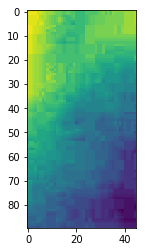

BurImagesJPG/train/color/good/20180924-200517GoodBur.jpg
(90, 45)


IndexError: index 175 is out of bounds for axis 0 with size 90

In [5]:
import cv2
from skimage import data
from skimage.transform import resize                       
%matplotlib inline                               

img = cv2.imread(train_files[2])
crop_img = img[20:400, 160:420]
# convert to grayscale
gray_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2GRAY)
# resize to smaller
#small_img = resize(crop_img, (205,115))
small_img = cv2.resize(gray_img, (0,0), fx=0.5, fy=0.5)
# rescale entries to lie in [0,1]
small_img_m = small_img.astype('float32')/255

# plot image
plt.imshow(small_img_m)
plt.show()
print train_files[2]
print small_img.shape
print small_img[175,90]
print small_img_m.shape
print small_img_m[175,90]
new_name = 'Bur_check' + train_files[2][10:]

cv2.imwrite(new_name,small_img,[cv2.IMWRITE_PNG_COMPRESSION, 9])
print new_name


(array([10.,  3.,  1.,  1.,  2.,  1.,  3.,  3.,  3.,  6.,  4.,  2.,  6.,
         1.,  2.,  1.,  1.,  3.,  2.,  1.,  2.,  2.,  4.,  2.,  3.,  2.,
         3.,  4.,  2., 10.]),
 array([23.11764908, 23.25921764, 23.40078621, 23.54235477, 23.68392334,
        23.82549191, 23.96706047, 24.10862904, 24.2501976 , 24.39176617,
        24.53333473, 24.6749033 , 24.81647186, 24.95804043, 25.09960899,
        25.24117756, 25.38274612, 25.52431469, 25.66588326, 25.80745182,
        25.94902039, 26.09058895, 26.23215752, 26.37372608, 26.51529465,
        26.65686321, 26.79843178, 26.94000034, 27.08156891, 27.22313747,
        27.36470604]),
 <a list of 30 Patch objects>)

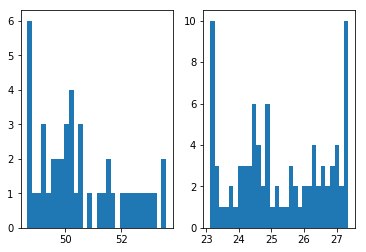

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(np.sum(small_img_m, axis=0), bins=30)
ax2.hist(np.sum(small_img_m, axis=1), bins=30)

In [6]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    #print img_path
    # loads RGB image as PIL.Image.Image type
    #img = image.load_img(img_path, target_size=(224, 224))
    img = cv2.imread(img_path)
    #crop_img = img[20:400, 160:420]
    # convert to grayscale
    #gray_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    # resize to smaller
    # dimensions of our images.
    #img_width, img_height = 205, 115
    #small_img = cv2.resize(crop_img, (0,0), fx=0.5, fy=0.5)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    
    # Save images to check    
    #new_name = 'Bur_check' + img_path[10:]
    #cv2.imwrite(new_name,small_img,[cv2.IMWRITE_PNG_COMPRESSION, 9])
    
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [7]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
validation_tensors = paths_to_tensor(validation_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 126/126 [00:00<00:00, 382.33it/s]


In [8]:
print train_tensors.shape
print train_tensors[0].shape
print np.sum(train_tensors[1])
print train_tensors[2,175,90]
Mostra = train_tensors[1].astype('float32')*255
print Mostra[175,90]
#plt.imshow(Mostra)
#plt.show()

(674, 200, 250, 3)
(200, 250, 3)
4277.675
[0.5254902  0.54901963 0.54509807]
[1. 1. 1.]


(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <a list of 30 Patch objects>)

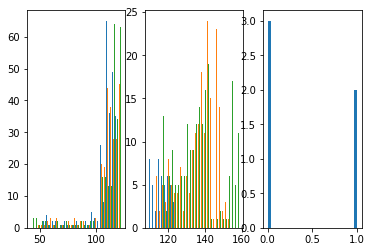

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.hist(np.sum(train_tensors[2], axis=0), bins=30)
ax2.hist(np.sum(train_tensors[2], axis=1), bins=30) 
ax3.hist(train_targets[0:5,0], bins=30) 

([array([189.,   0.,   0.,   0.,  11.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([185.,   0.,   0.,   0.,   7.,   0.,   0.,   0.,   3.,   0.,   0.,
           0.,   2.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([86.,  0.,  0.,  0., 16.,  0.,  0.,  0., 32.,  0.,  0.,  0., 27.,
          0.,  0.,  0.,  0., 14.,  0.,  0.,  0., 13.,  0.,  0.,  0.,  9.,
          0.,  0.,  0.,  3.])],
 array([0.        , 0.23333333, 0.46666667, 0.7       , 0.93333333,
        1.16666667, 1.4       , 1.63333333, 1.86666667, 2.1       ,
        2.33333333, 2.56666667, 2.8       , 3.03333333, 3.26666667,
        3.5       , 3.73333333, 3.96666667, 4.2       , 4.43333333,
        4.66666667, 4.9       , 5.13333333, 5.36666667, 5.6       ,
        5.83333333, 6.06666667, 6.3       , 6.53333333, 6.7666

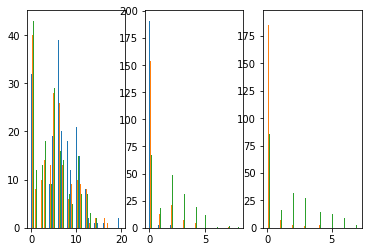

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.hist(np.sum(test_tensors[0]==0, axis=1), bins=30)
ax2.hist(np.sum(test_tensors[1]==0, axis=1), bins=30)
ax3.hist(np.sum(test_tensors[2]==0, axis=1), bins=30)

In [9]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import RMSprop
# Building the model architecture with one layer of length 100
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(200,250,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(len(bur_classes), activation='softmax'))
model.summary()
# Compile model
epochs = 50
learning_rate = 0.0001
decay_rate = learning_rate / epochs
momentum = 0.8
#sgd = SDG(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
#sgd = Adam(lr=learning_rate, decay=decay_rate)
sgd = RMSprop(lr=learning_rate, decay=decay_rate)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 250, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 125, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 125, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 125, 32)      12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 62, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 62, 16)        12816     
__________

In [10]:
score = model.evaluate(train_tensors, train_targets, verbose=0)
print("accuracy: ", score[1])

KeyboardInterrupt: 

In [ ]:
from keras.callbacks import ModelCheckpoint  



### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(validation_tensors, validation_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 674 samples, validate on 136 samples
Epoch 1/10
674/674 [==============================] - 1594s 2s/step - loss: 0.6944 - acc: 0.5475 - val_loss: 0.6939 - val_acc: 0.4338

Epoch 00001: val_loss improved from inf to 0.69390, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/10
600/674 [=========================>....] - ETA: 1:45 - loss: 0.6519 - acc: 0.6300

In [25]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

model = Sequential()
model.add(Conv2D(32, (2, 2), padding='same', activation='relu', input_shape=(200,250,3)))
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (2, 2), padding='same', activation='relu'))
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(64, (2, 2), padding='same', activation='relu'))
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(len(bur_classes), activation='softmax'))
model.summary()

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# Compiling the model using categorical_crossentropy loss, and rmsprop optimizer.
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Compile model
from keras.optimizers import RMSprop
epochs = 10
learning_rate = 0.0001
decay_rate = learning_rate / epochs
momentum = 0.8
optimizer = RMSprop(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 200, 250, 32)      416       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 199, 249, 32)      4128      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 99, 124, 32)       0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 99, 124, 32)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 99, 124, 64)       8256      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 98, 123, 64)       16448     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 49, 61, 64)        0         
__________

In [ ]:
from keras.callbacks import ModelCheckpoint  



### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_tensors)

# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=32),
                    validation_data=(validation_tensors, validation_targets),
                    steps_per_epoch=len(train_tensors) / 32, epochs=epochs, callbacks=[checkpointer], verbose=1)

#model.fit(train_tensors, train_targets, 
#          validation_data=(validation_tensors, validation_targets),
#          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/10
21/21 [==============================] - 1823s 87s/step - loss: 0.7086 - acc: 0.4608 - val_loss: 0.6931 - val_acc: 0.4926

Epoch 00001: val_loss improved from inf to 0.69312, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/10
21/21 [==============================] - 3401s 162s/step - loss: 0.6900 - acc: 0.5045 - val_loss: 0.6928 - val_acc: 0.4926

Epoch 00002: val_loss improved from 0.69312 to 0.69277, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/10
21/21 [==============================] - 1743s 83s/step - loss: 0.6887 - acc: 0.5239 - val_loss: 0.6929 - val_acc: 0.4926

Epoch 00003: val_loss did not improve
Epoch 4/10
 9/21 [===========>..................] - ETA: 1:03:24 - loss: 0.6929 - acc: 0.5382

In [ ]:
score = model.evaluate(train_tensors, train_targets, verbose=0)
print("accuracy: ", score[1])